### Setup

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


#### Install Pytorch Geometric Temporal

In [2]:
!pip install torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 10.9 MB/s eta 0:00:00


In [3]:
import torch

TORCH = torch.__version__.split('+')[0]
CUDA = 'cu' + torch.version.cuda.replace('.', '')

# Construct the installation command
install_command = f"pip install pyg_lib torch_scatter torch_sparse torch_cluster torch_spline_conv -f https://data.pyg.org/whl/torch-{TORCH}+{CUDA}.html"

# Execute the command
!{install_command}

Looking in links: https://data.pyg.org/whl/torch-2.1.0+cu118.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 24.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 76.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 87.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 103.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 887.8/887.8 kB 65.5 MB/s eta 0:00:00


In [4]:
import numpy as np
import os

# Set a random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

### `ASLDatasetLoader` Class

The `ASLDatasetLoader` class is designed for loading and processing the ASL dataset. Given a directory, it reads sign language data from JSON files and constructs graph representations suitable for graph-based neural networks. Crucially, the class converts JSON data into PyTorch Geometric (PyG) `Data` objects comprising `x` (node features), `edge_index` (graph connectivity), and `y' (labels) attributes.

**Methods**:

- `_create_sign_to_label_map`: Generates a mapping from sign names to unique labels.

- `_read_file_data`: Reads data from a given JSON file.

- `_augment_data`: Implements data augmentation by applying random rotation, translation, and scaling to landmarks, which can enhance the model's robustness.

- `_create_graph_from_frame`: Constructs a PyG `Data` object from frame data, concentrating on hand and face landmarks. Edges are created between consecutive landmarks and between left and right hand landmarks. Additional features, like hand-to-face distances, are also computed.

- `get_dataset`: Assembles the dataset, optionally incorporating data augmentation. The function outputs a list of PyG `Data` objects ready for graph neural network processing.

In [5]:
import json
from torch_geometric.data import Data

class ASLDatasetLoader:
    # Define natural connections as class attributes
    HAND_CONNECTIONS = frozenset([
      # Left hand palm
      ("left_hand-0", "left_hand-1"),
      ("left_hand-0", "left_hand-5"),
      ("left_hand-9", "left_hand-13"),
      ("left_hand-13", "left_hand-17"),
      ("left_hand-5", "left_hand-9"),
      ("left_hand-0", "left_hand-17"),
      # Left hand thumb
      ("left_hand-1", "left_hand-2"),
      ("left_hand-2", "left_hand-3"),
      ("left_hand-3", "left_hand-4"),
      # Left hand index finger
      ("left_hand-5", "left_hand-6"),
      ("left_hand-6", "left_hand-7"),
      ("left_hand-7", "left_hand-8"),
      # Left hand middle finger
      ("left_hand-9", "left_hand-10"),
      ("left_hand-10", "left_hand-11"),
      ("left_hand-11", "left_hand-12"),
      # Left hand ring finger
      ("left_hand-13", "left_hand-14"),
      ("left_hand-14", "left_hand-15"),
      ("left_hand-15", "left_hand-16"),
      # Left hand pinky
      ("left_hand-17", "left_hand-18"),
      ("left_hand-18", "left_hand-19"),
      ("left_hand-19", "left_hand-20"),
      # Right hand palm
      ("right_hand-0", "right_hand-1"),
      ("right_hand-0", "right_hand-5"),
      ("right_hand-9", "right_hand-13"),
      ("right_hand-13", "right_hand-17"),
      ("right_hand-5", "right_hand-9"),
      ("right_hand-0", "right_hand-17"),
      # Right hand thumb
      ("right_hand-1", "right_hand-2"),
      ("right_hand-2", "right_hand-3"),
      ("right_hand-3", "right_hand-4"),
      # Right hand index finger
      ("right_hand-5", "right_hand-6"),
      ("right_hand-6", "right_hand-7"),
      ("right_hand-7", "right_hand-8"),
      # Right hand middle finger
      ("right_hand-9", "right_hand-10"),
      ("right_hand-10", "right_hand-11"),
      ("right_hand-11", "right_hand-12"),
      # Right hand ring finger
      ("right_hand-13", "right_hand-14"),
      ("right_hand-14", "right_hand-15"),
      ("right_hand-15", "right_hand-16"),
      # Right hand pinky
      ("right_hand-17", "right_hand-18"),
      ("right_hand-18", "right_hand-19"),
      ("right_hand-19", "right_hand-20"),
    ])

    POSE_CONNECTIONS = frozenset([
      ("pose-0", "pose-1"),
      ("pose-1", "pose-2"),
      ("pose-2", "pose-3"),
      ("pose-3", "pose-7"),
      ("pose-0", "pose-4"),
      ("pose-4", "pose-5"),
      ("pose-5", "pose-6"),
      ("pose-6", "pose-8"),
      ("pose-9", "pose-10"),
      ("pose-11", "pose-12"),
      ("pose-11", "pose-13"),
      ("pose-13", "pose-15"),
      ("pose-15", "pose-17"),
      ("pose-12", "pose-14"),
      ("pose-14", "pose-16"),
      ("pose-16", "pose-18"),
      ("pose-11", "pose-23"),
      ("pose-12", "pose-24"),
      ("pose-23", "pose-24"),
    ])

    FACE_CONNECTIONS = frozenset([
      # Connections for FACEMESH_LIPS using available landmarks
      ("face-61", "face-146"), ("face-146", "face-91"), ("face-91", "face-181"),
      ("face-181", "face-84"), ("face-84", "face-17"), ("face-17", "face-314"),
      ("face-314", "face-405"), ("face-405", "face-321"), ("face-321", "face-375"),
      ("face-375", "face-291"), ("face-78", "face-95"), ("face-95", "face-88"),
      ("face-88", "face-178"), ("face-178", "face-87"), ("face-87", "face-14"),
      ("face-14", "face-317"), ("face-317", "face-402"), ("face-402", "face-318"),
      ("face-318", "face-324"), ("face-324", "face-308"),

      # Connections for FACEMESH_LEFT_EYE using available landmarks
      ("face-263", "face-249"), ("face-388", "face-387"), ("face-387", "face-386"),
      ("face-386", "face-385"), ("face-385", "face-384"), ("face-384", "face-398"),

      # Connections for FACEMESH_LEFT_EYEBROW using available landmarks
      ("face-276", "face-283"), ("face-300", "face-293"), ("face-293", "face-334"),
      ("face-334", "face-296"), ("face-296", "face-336"),

      # Connections for FACEMESH_RIGHT_EYE using available landmarks
      ("face-33", "face-7"), ("face-246", "face-161"), ("face-161", "face-160"),
      ("face-160", "face-159"), ("face-159", "face-158"), ("face-158", "face-157"),
      ("face-157", "face-173"),

      # Connections for FACEMESH_RIGHT_EYEBROW using available landmarks
      ("face-46", "face-53"), ("face-70", "face-63"), ("face-63", "face-105"),
      ("face-105", "face-66"), ("face-66", "face-107"),

      # Connections for FACEMESH_FACE_OVAL using available landmarks
      ("face-10", "face-338"), ("face-338", "face-297"), ("face-297", "face-332"),
      ("face-332", "face-284"), ("face-284", "face-251"), ("face-251", "face-389"),
      ("face-389", "face-356"), ("face-356", "face-454"), ("face-454", "face-323"),
      ("face-323", "face-361"), ("face-361", "face-288"), ("face-288", "face-397"),
      ("face-397", "face-365"), ("face-365", "face-379"), ("face-379", "face-378"),
      ("face-378", "face-400"), ("face-400", "face-377"), ("face-377", "face-152"),
      ("face-152", "face-148"), ("face-148", "face-176"), ("face-176", "face-149"),
      ("face-149", "face-150"), ("face-150", "face-136"), ("face-136", "face-172"),
      ("face-172", "face-58"), ("face-58", "face-132"), ("face-132", "face-93"),
      ("face-93", "face-234"), ("face-234", "face-127"), ("face-127", "face-162"),
      ("face-162", "face-21"), ("face-21", "face-54"), ("face-54", "face-103"),
      ("face-103", "face-67"), ("face-67", "face-109"), ("face-109", "face-10"),
    ])

    def __init__(self, directory_path, min_examples_per_class=2, max_files=-1):
        self.directory_path = directory_path
        self.min_examples_per_class = min_examples_per_class
        self.max_files = max_files
        self.sign_to_label = self._create_sign_to_label_map()

    def _create_sign_to_label_map(self):
        signs = [os.path.splitext(filename)[0] for filename in os.listdir(self.directory_path)]
        return {sign: i for i, sign in enumerate(signs)}

    def _read_file_data(self, file_path):
        with open(file_path, 'r') as f:
            data = json.load(f)

        sign_name = data["sign"]
        num_examples = len(data["examples"])
        print(f"Loaded sign '{sign_name}' with {num_examples} examples")

        return data if num_examples >= self.min_examples_per_class else None


    def _augment_data(frame_data, rotation_range=10, translation_range=0.05, scaling_range=0.1):
        """
        Augment the frame data with random rotation, translation, and scaling.

        :param frame_data: Dictionary containing frame landmarks and deltas.
        :param rotation_range: Maximum rotation angle in degrees.
        :param translation_range: Maximum translation as a fraction of landmark range.
        :param scaling_range: Maximum scaling factor.
        :return: Augmented frame data.
        """
        # Extract landmarks
        landmarks = np.array([[landmark['x'], landmark['y']] for landmark in frame_data['landmarks']])
        centroid = np.mean(landmarks, axis=0)

        # Random rotation
        theta = np.radians(np.random.uniform(-rotation_range, rotation_range))
        rotation_matrix = np.array([
            [np.cos(theta), -np.sin(theta)],
            [np.sin(theta), np.cos(theta)]
        ])
        landmarks = np.dot(landmarks - centroid, rotation_matrix) + centroid

        # Random translation
        max_translation = translation_range * (landmarks.max(axis=0) - landmarks.min(axis=0))
        translations = np.random.uniform(-max_translation, max_translation, size=landmarks.shape[1])
        landmarks += translations

        # Random scaling
        scale = np.random.uniform(1 - scaling_range, 1 + scaling_range)
        landmarks = centroid + scale * (landmarks - centroid)

        # Update the landmarks in frame_data
        for i, landmark in enumerate(frame_data['landmarks']):
            landmark['x'], landmark['y'] = landmarks[i]

        return frame_data

    def _create_graph_from_frame(self, sign_name, sign_data):
        graphs = []

        for example in sign_data["examples"]:
            all_features = []  # Combined list for landmarks, velocities, and accelerations
            edges = []

            for frame in example["frames"]:
                for landmark_data in frame["landmarks"]:
                    # Extract spatial coordinates
                    landmark_features = [landmark_data["x"], landmark_data["y"]]

                    # Extract temporal data (velocity and acceleration)
                    temporal_data = next((item for item in frame["temporal"] if item["landmark"] == landmark_data["landmark"]), None)
                    if temporal_data:
                        velocity = [temporal_data["velocity"]["x"], temporal_data["velocity"]["y"]]
                        acceleration = [temporal_data["acceleration"]["x"], temporal_data["acceleration"]["y"]]
                    else:
                        velocity = [0, 0]
                        acceleration = [0, 0]

                    # Combine spatial and temporal features
                    combined_features = landmark_features + velocity + acceleration
                    all_features.append(combined_features)

                # Add spatial edges within the frame using natural connections
                for i in range(len(frame["landmarks"])):
                    for j in range(len(frame["landmarks"])):
                        if i != j:
                            connection = (frame["landmarks"][i]["landmark"], frame["landmarks"][j]["landmark"])
                            if connection in self.HAND_CONNECTIONS or \
                              connection in self.POSE_CONNECTIONS or \
                              connection in self.FACE_CONNECTIONS:
                                edges.append([len(all_features) - len(frame["landmarks"]) + i,
                                              len(all_features) - len(frame["landmarks"]) + j])

            # Add temporal edges between frames within each example
            for i in range(len(example["frames"]) - 1):
                for j in range(len(frame["landmarks"])):
                    start_index = i * len(frame["landmarks"]) + j
                    end_index = (i + 1) * len(frame["landmarks"]) + j
                    edges.append([start_index, end_index])

            # Create the graph
            x = torch.tensor(all_features, dtype=torch.float)
            edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()
            y = torch.tensor([self.sign_to_label[sign_name]], dtype=torch.long)

            # Append the graph for the current example to the list of graphs
            graphs.append(Data(x=x, edge_index=edge_index, y=y))

        return graphs

    def get_dataset(self, augment=False):
        dataset = []
        file_count = 0

        for filename in os.listdir(self.directory_path):
            if 0 <= self.max_files <= file_count:
                break  # Stop if max_files limit is reached

            sign_name = os.path.splitext(filename)[0]
            file_path = os.path.join(self.directory_path, filename)
            sign_data = self._read_file_data(file_path)
            file_count += 1

            if sign_data is None:
                print(f"Skipping sign '{sign_name}' due to insufficient examples")
                continue

            # Retrieve a list of graphs, one for each example
            graphs = self._create_graph_from_frame(sign_name, sign_data)

            # Debugging: Check the number of graphs created for the current sign
            print(f"Sign '{sign_name}': Created {len(graphs)} graphs")

            dataset.extend(graphs)  # Extend the dataset with the list of graphs

        return dataset

    def number_of_classes(self):
        return len(self.sign_to_label)

### `ASLGraphClassifier` Class

The `ASLGraphClassifier`, features deeper GCN layers and additional channels to capture intricate data patterns potentially. It takes a PyG `Data` object as input, and its forward pass emits class logits.

**Methods**:

- `forward`: Details the forward pass, accepting a PyG `Data` object. Two GCN layers with subsequent batch normalization and dropout layers process the input. Post global max-pooling, two linear layers coupled with dropout ensure final classification, leading to log-softmax outputs.

In [6]:
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, global_max_pool, BatchNorm

class ASLGraphClassifier(torch.nn.Module):
    def __init__(self, num_features, num_classes):
        super(ASLGraphClassifier, self).__init__()
        self.conv1 = GCNConv(num_features, 512)
        self.bn1 = BatchNorm(512)
        self.conv2 = GCNConv(512, 1024)
        self.bn2 = BatchNorm(1024)
        self.lin1 = torch.nn.Linear(1024, 512)
        self.lin2 = torch.nn.Linear(512, num_classes)

        # Increased dropout rate for more regularization
        self.dropout = torch.nn.Dropout(p=0.5)

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch

        # Apply dropout after each GCN layer and fully connected layer
        x = F.relu(self.bn1(self.conv1(x, edge_index)))
        x = self.dropout(x)
        x = F.relu(self.bn2(self.conv2(x, edge_index)))
        x = self.dropout(x)

        x = global_max_pool(x, batch)

        x = F.relu(self.lin1(x))
        x = self.dropout(x)
        x = self.lin2(x)
        return F.log_softmax(x, dim=1)


In [7]:
from sklearn.model_selection import train_test_split
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch_geometric.loader import DataLoader
from collections import Counter
import random

EPOCHS = 100
LEARNING_RATE = 0.0001


def stratified_data_split(data_list, test_size=0.2):
    """
    This function splits a dataset into training and testing subsets, preserving
    the class distribution by leveraging the stratification capabilities of
    `train_test_split` from `sklearn`. Stratification helps with potential class
    imbalances.
    """
    # Extract labels from data list
    labels = [data.y.item() for data in data_list]

    # Use sklearn's train_test_split with stratify option
    train_data, test_data = train_test_split(data_list, test_size=test_size, stratify=labels, random_state=42)

    return train_data, test_data


def validate(loader, model, device):
    """
    Used to evaluate the model on validation/test data, computing accuracy as a
    performance metric, and offering insights into the model's efficacy.
    """
    model.eval()
    correct = 0
    for data in loader:
        data = data.to(device)
        with torch.no_grad():
            out = model(data)
        pred = out.argmax(dim=1)
        correct += int((pred == data.y).sum())
    return correct / len(loader.dataset)

def train(loader):
    """
    The `train` function establishes the training loop for the graph-based
    neural network. It enacts typical training loop tasks like logging
    epoch-wise loss, validation, and early stopping.

    The function also harnesses schedulers, regularization techniques, and
    gradient clipping to ensure smooth and optimal training.
    """

    # Create the entire dataset without augmentation and then perform stratified split
    data_list = loader.get_dataset()
    train_dataset, test_dataset = stratified_data_split(data_list, test_size=0.2)

    # Now augment only the training dataset
    augmented_train_dataset = loader.get_dataset(augment=True)

    num_classes = loader.number_of_classes()

    train_labels = [data.y.item() for data in train_dataset]
    test_labels = [data.y.item() for data in test_dataset]

    print("Training label distribution:", Counter(train_labels))
    print("Test label distribution:", Counter(test_labels))

    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    num_features = train_dataset[0].x.size(1)
    model = ASLGraphClassifier(num_features=num_features, num_classes=num_classes).to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=5e-4)
    scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.7, patience=10, verbose=True)

    max_epochs_without_improvement = 20
    epochs_without_improvement = 0
    best_val_accuracy = 0

    model.train()
    for epoch in range(EPOCHS):
        total_loss = 0
        correct_train = 0
        total_train = 0

        for batch in train_loader:
            batch = batch.to(device)
            optimizer.zero_grad()
            out = model(batch)
            loss = F.nll_loss(out, batch.y)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1)
            optimizer.step()
            total_loss += loss.item()

            # Calculate training accuracy
            pred_train = out.argmax(dim=1)
            correct_train += int((pred_train == batch.y).sum())
            total_train += batch.y.size(0)

            if np.isnan(loss.item()):
                print("Warning: NaN loss detected!")

        avg_loss = total_loss / len(train_loader)
        train_accuracy = correct_train / total_train
        val_accuracy = validate(test_loader, model, device)

        print(f"Epoch {epoch}, Loss: {avg_loss:.4f}, Training Accuracy: {train_accuracy:.4f}, Validation Accuracy: {val_accuracy:.4f}")

        scheduler.step(val_accuracy)

        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            epochs_without_improvement = 0
        else:
            epochs_without_improvement += 1

        if epochs_without_improvement >= max_epochs_without_improvement:
            print("Early stopping triggered.")
            break

    model.eval()
    correct = 0
    all_preds = []
    all_labels = []

    for batch in test_loader:
        batch = batch.to(device)
        with torch.no_grad():
            pred = model(batch).max(dim=1)[1]
            all_preds.extend(pred.cpu().numpy())
            all_labels.extend(batch.y.cpu().numpy())
            correct += pred.eq(batch.y).sum().item()

    accuracy = correct / len(test_dataset)

    print(f"Accuracy: {accuracy}")
    print("Sample predictions:", all_preds[:20])
    print("Sample true labels:", all_labels[:20])

    return model, all_preds, all_labels, accuracy


In [8]:
MAX_FILES = 5
directory_path = "/content/drive/MyDrive/Colab Notebooks/DGMD E-14 Project/Datasets/processed-40-500"
loader = ASLDatasetLoader(directory_path, max_files=MAX_FILES)

model, all_preds, all_labels, accuracy = train(loader)

Loaded sign 'TV' with 385 examples
Sign 'TV': Created 385 graphs
Loaded sign 'after' with 347 examples
Sign 'after': Created 347 graphs
Loaded sign 'airplane' with 393 examples
Sign 'airplane': Created 393 graphs
Loaded sign 'all' with 386 examples
Sign 'all': Created 386 graphs
Loaded sign 'alligator' with 390 examples
Sign 'alligator': Created 390 graphs
Loaded sign 'TV' with 385 examples
Sign 'TV': Created 385 graphs
Loaded sign 'after' with 347 examples
Sign 'after': Created 347 graphs
Loaded sign 'airplane' with 393 examples
Sign 'airplane': Created 393 graphs
Loaded sign 'all' with 386 examples
Sign 'all': Created 386 graphs
Loaded sign 'alligator' with 390 examples
Sign 'alligator': Created 390 graphs
Training label distribution: Counter({2: 314, 4: 312, 3: 309, 0: 308, 1: 277})
Test label distribution: Counter({2: 79, 4: 78, 3: 77, 0: 77, 1: 70})
Epoch 0, Loss: 2.2615, Training Accuracy: 0.2263, Validation Accuracy: 0.2205
Epoch 1, Loss: 1.6028, Training Accuracy: 0.2250, Valid

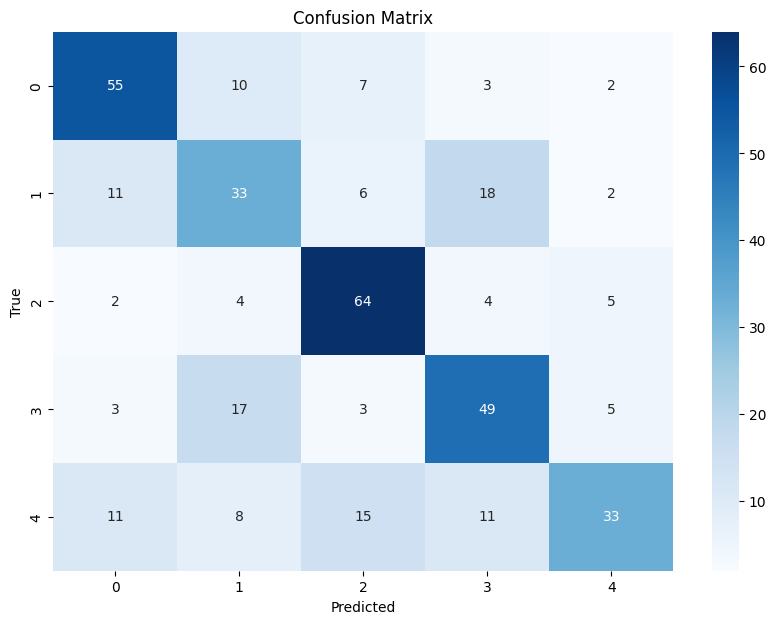

Accuracy for class 0 (TV): 71.43%
Accuracy for class 1 (after): 47.14%
Accuracy for class 2 (airplane): 81.01%
Accuracy for class 3 (all): 63.64%
Accuracy for class 4 (alligator): 42.31%

Classification Report:

              precision    recall  f1-score   support

          TV       0.67      0.71      0.69        77
       after       0.46      0.47      0.46        70
    airplane       0.67      0.81      0.74        79
         all       0.58      0.64      0.60        77
   alligator       0.70      0.42      0.53        78

    accuracy                           0.61       381
   macro avg       0.62      0.61      0.61       381
weighted avg       0.62      0.61      0.61       381



In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

# Convert lists to numpy arrays for compatibility with sklearn
y_true = np.array(all_labels)
y_pred = np.array(all_preds)

# Calculate the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Visualize the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# Ensure the class names are in the correct order for target_names
ordered_class_names = [name for name, num in sorted(loader.sign_to_label.items(), key=lambda item: item[1])]

# Per-Class Accuracy
class_accuracy = cm.diagonal() / cm.sum(axis=1)
for i, acc in enumerate(class_accuracy):
    class_name = ordered_class_names[i]
    print(f"Accuracy for class {i} ({class_name}): {acc*100:.2f}%")

# Detailed classification report
print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, target_names=ordered_class_names, zero_division=1))

In [10]:
from sklearn.metrics import classification_report

def print_top_misclassified_classes(y_true, y_pred, sign_to_label, N=3, zero_division=1):
    """
    Prints the top N classes that get misclassified the most.

    Parameters:
    - y_true: Actual labels
    - y_pred: Predicted labels by the model
    - sign_to_label: Dictionary mapping class names to class numbers
    - N: Number of top misclassified classes to print
    - zero_division: Parameter for handling zero division in classification_report

    Returns:
    None
    """

    # Ensure the class names are in the correct order for target_names
    ordered_class_names = [name for name, num in sorted(sign_to_label.items(), key=lambda item: item[1])]

    # Generate and print classification report with class names
    print("\nClassification Report:\n")
    print(classification_report(y_true, y_pred, target_names=ordered_class_names, zero_division=zero_division))

    # Generate classification report as dict to find misclassified classes
    report = classification_report(y_true, y_pred, output_dict=True, zero_division=zero_division)

    # Create a dictionary to store misclassification rates
    misclassification_rates = {}

    # Iterate through each class in the report
    for class_num, metrics in report.items():
        if class_num.isdigit():
            class_name = [key for key, value in sign_to_label.items() if value == int(class_num)][0]
            misclassification_rates[class_name] = 1 - metrics['recall']

    # Sort classes based on misclassification rate
    sorted_classes = sorted(misclassification_rates, key=misclassification_rates.get, reverse=True)

    # Print top N misclassified classes
    print(f"\nTop {N} misclassified classes:")
    for i in range(N):
        class_name = sorted_classes[i]
        print(f"{i+1}. {class_name} - Misclassification rate: {misclassification_rates[class_name]:.2f}")

In [11]:
N = 10 if MAX_FILES > 50 else MAX_FILES
print_top_misclassified_classes(y_true, y_pred, loader.sign_to_label, N=N, zero_division=1)


Classification Report:

              precision    recall  f1-score   support

          TV       0.67      0.71      0.69        77
       after       0.46      0.47      0.46        70
    airplane       0.67      0.81      0.74        79
         all       0.58      0.64      0.60        77
   alligator       0.70      0.42      0.53        78

    accuracy                           0.61       381
   macro avg       0.62      0.61      0.61       381
weighted avg       0.62      0.61      0.61       381


Top 5 misclassified classes:
1. alligator - Misclassification rate: 0.58
2. after - Misclassification rate: 0.53
3. all - Misclassification rate: 0.36
4. TV - Misclassification rate: 0.29
5. airplane - Misclassification rate: 0.19
